## Problème de prédiction du type de cancer de la peau : distinction entre tumeurs bénignes et malignes à l’aide des couches conv2D

Dans le Lab 1 et 2, nous avons appris à utiliser les algorithmes de l'apprentissage automatique, un Multi-Layer Perceptron, et une couche de convolution 1D pour construire un modèle de classification capable de distinguer les tumeurs bénignes des tumeurs malignes.

Aujourd'hui, nous allons explorer l'utilisation des couches de convolution en 2D.

Pour cela, nous allons utiliser la bibliothèque Keras, en particulier la couche Conv2D, afin de résoudre ce problème de classification.

À la fin de ce TP, vous serez capable de :

 - définir un problème d'apprentissage machine.

 - comprendre le mécanisme de fonctionnement d'une couche de convolution 2D.

 - connaître l'implémentation d'une couche de convolution 2D à l'aide de la bibliothèque Keras.

 - comprendre les techniques d'augmentation des données par transformation des images, notamment (normalization, scaling, tilting, resizing).

 - savoir implémenter un script pour identifier les régions les plus pertinentes pour un modèle d'apprentissage notamment, mettre en évidence la région d'une image
 sur laquelle les yeux des gens se concentrent en premier (saliency maps).

C'est parti !

## Table de matière

 - Importation des bibliothèques essentielles

 - Partie 0:

    - Définir le type de problème d'apprentissage machine

 - Partie 1:

    - Extraction des données

    - Chargement des données 

    - Transformation des données

 - Partie 2:
   
    - Visualisation des données 


 - Partie 3:

    - Encodage de la variable cible


 - Partie 4:

    - Section des données en sous-échantillons de données (données d'entraînement de validation et de test)


 - Partie 5:

    - Implémentation de l'algorithme

 - Partie 6:

    - Entraînement du modèle

 - Partie 7:

    - Tester et valider le modèle


 - Partie 8:

    - Inférence

 - Partie 9:

    - Modèle pré-entraîné:

 - Partie 10:
    - Augmentation des données avec ImageDataGenerator



## Importer les bibliothèques essentielles

In [3]:
! pip install pandas
! pip install scikit-learn
! pip install opencv-python
! pip install tensorflow
! pip install --upgrade keras
! pip install pydot
! pip install numpy
! pip install matplotlib

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.1.24-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.8.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 612.2 kB/s eta 0:00:00m eta 0:00:0136m0:00:11
Using cached absl_py-2.1.0-py3-none-a

In [4]:
from pathlib import Path
from  glob import glob
import os
import cv2
import copy
import time
import random

In [5]:
import numpy as  np
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv1D, MaxPooling1D, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Rescaling
from tensorflow.keras.optimizers import Adam, SGD, schedules
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras import callbacks, applications, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

## Partie 0

- Définir le type de problème d'apprentissage machine

...

## Partie 1

- Extraction des données

- Chargement des données 

- Transformation des données

#### Définition d'une classe pour charger et transformer les données

In [8]:

class CustomDataset:
    def __init__(self, proportion: float, root: Path, train: bool, size : tuple,shuffle:bool, normalize: bool):
        """
        Initialisation de l'objet CustomDataset avec la proportion des données à utiliser
        et le répertoire racine contenant les images.

        :param proportion: Proportion des données à charger (0 à 1).
        :param root: Répertoire racine où se trouvent les images.
        """
        self.proportion = proportion

        self.root = root

        self.data = {"images": [], "Target": []}

        self.target = ["benign", "malignant"]
       
        self.dataType = "train" if train else "test" 

        self.size =  size

        self.normalize = normalize

        self.shuffle = shuffle
    

    def dataloader(self):
        """
        Charge et traite les images depuis les répertoires 'benign' et 'malignant', 
        en appliquant une proportion des données spécifiée.

        :return: Tuple contenant les caractéristiques (Images) et les cibles (Target) des données.
        """
        
        # Initialisation des listes pour les images et les cibles
        images = []

        targets = []
        
        # Chargement des images et valeurs cibles benign et malignant
        for item in self.target:
            files = glob(os.path.join(self.root, f"{self.dataType}/{item}/*.jpg"))
            num_files = int(len(files) * self.proportion)

            # Ajout des images et des cibles dans les listes correspondantes
            images.extend([cv2.resize(cv2.imread(imagePath) / 255.0, self.size).astype(np.float32) 
                        if self.normalize else cv2.resize(cv2.imread(imagePath), self.size).astype(np.float32) 
                        for imagePath in files[:num_files]])

            targets.extend([item for _ in range(num_files)])

        # Combinaison des images et cibles en une seule liste de tuples
        combined = list(zip(images, targets))

        # Mélange des données si shuffle est True
        if self.shuffle:
            random.shuffle(combined)

        # Séparation des images et cibles après le shuffle
        self.data["images"], self.data["Target"] = zip(*combined)

        return list(self.data["images"]), list(self.data["Target"])


### Charger les données disponibles dans un dossier dont vous connaissez le chemin

#### Définir le chemin vers le dossier contenant les données

In [9]:

root = ".../cours/CV50/inputs/raw/data/"

##### Définir la proportion des données à charger

In [10]:
proportion = ...

##### Charger et transformer les données

In [11]:
datasets = ...

In [12]:
images , target = datasets.dataloader()

 - Partie 2:
   
    - Visualisation des données 

#### Afficher aléatoirement 9 images de type de cancer de la peau

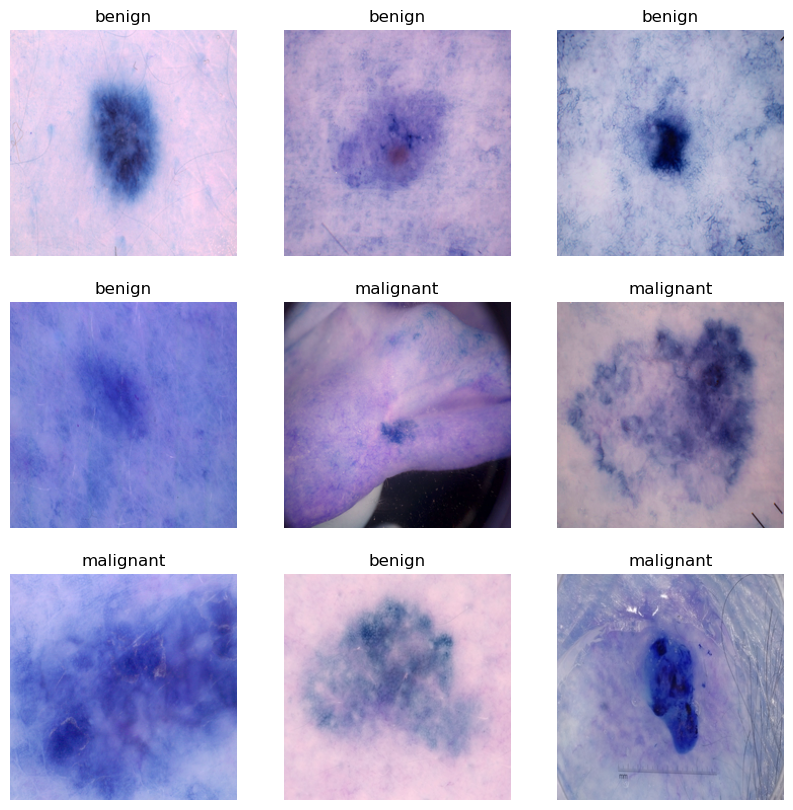

In [13]:
plt.figure(figsize=(10, 10))
i = 0
for  image, label in zip(images[:9],target[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(image*255).astype("uint8"))
    plt.title(label)
    plt.axis("off")
    i+=1

#### Afficher une image de type de cancer de la peau sur 4 canaux d'encodage d'image (red, green, blue, gris)

In [14]:
#Définir l'image
images_ = images[:9]

idx = random.randint(a=1, b=8)

image = images_[idx]

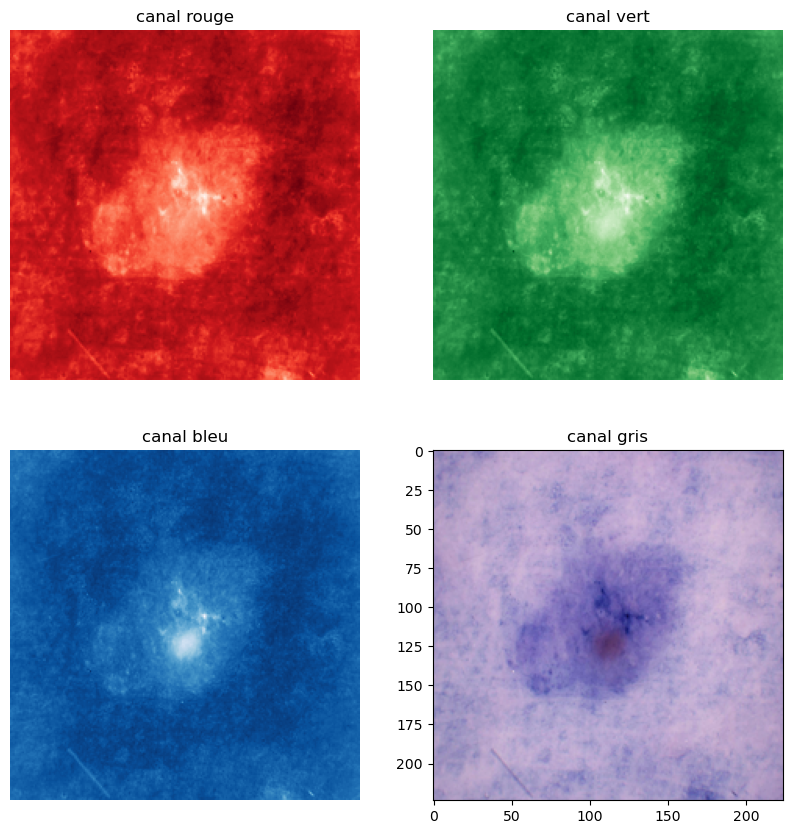

In [15]:
colors = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues, plt.cm.Greys]
labels = ["canal rouge", "canal vert", "canal bleu", "canal gris"]

plt.figure(figsize=(10, 10))

i = 0

for color, label in zip(colors, labels):
    ax = plt.subplot(2, 2, i + 1)

    if i<3:
        plt.imshow(image[:,:,i], cmap=color)
        plt.title(label)
        plt.axis("off")
    else:
        plt.title(labels[i])
        plt.imshow(image) 
        plt.show()
    i+=1

## Partie 3:

- Encodage de la variable cible


#### Encoder la variable cible sous forme d'entier pour pouvoir faire l'entraînement

Exemple:

- benign -----> 0

- malignant ----> 1

#### Encoder les valeurs cibles à l'aide de map

In [16]:

target = [0 if item=='benign' else 1 for item in target]

#### Convertir en matrice de données

In [17]:
X_Train = np.array(images)
Y_Train = np.array(target)

## Partie 4:

 - Section des données en sous-échantillons de données (données d'entraînement de validation et de test)


In [18]:
# À l'aide de sklearn, écrivez une fonction pour diviser les données en ensemble d'apprentissage et de validation
x_train, x_val, y_train, y_val = train_test_split(X_Train, Y_Train, test_size=0.25, shuffle=True, random_state=42)

## Partie 5:

 - Implémentation de l'algorithme

#### Conv2D

Comme mentionné au cours, Un noyau de convolution est un masque utilisé pour transformer les images, notamment flouter, améliorer la qualité, déformer l’image, détecter les contours, et d'autres. Il permet d'extraire les informations pertinentes de l'image.

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS0EyCbjUVZp-BxyHS9c1aW9-ydxiG4fHXOSg&s" alt="description de l'image" width="700" height="250">






#### a) Conv2D de keras 

keras.layers.Conv2D (filters, kernel_size, strides=(1, 1), padding='valid', activation=None, use_bias=True, kernel_initializer='glorot_uniform', data_format='channels_last', bias_initializer='zeros')

#### b) Pooling layers

Cette couche permet de réduire la taille de la matrice de données et supprimer les informations inutiles. Cette couche utilise des opérations comme  le maximum :max() et la moyenne : avg()

<img src="https://www.researchgate.net/publication/333593451/figure/fig2/AS:765890261966848@1559613876098/llustration-of-Max-Pooling-and-Average-Pooling-Figure-2-above-shows-an-example-of-max.png" alt="description de l'image" width="700" height="350">


#### MaxPooling2D de keras

keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)

#### c) Dropout Layers
La couche Dropout permet au réseau de désactiver aléatoirement une portion de neurones pendant l'entraînement

Cette technique aide à prévenir le surapprentissage (overfitting)


<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/1IrdJ5PghD9YoOyVAQ73MJw.gif" alt="description de l'image" width="500" height="300">


#### Dropout avec keras 

keras.layers.Dropout(rate, seed=None)

#### d) Couches densement connectées

Une couche entièrement connectée est la partie linéaire du réseau. Elle permet de projeter un vecteur dans une dimension plus petite.

À la sortie de celle-ci, nous pouvons utiliser une fonction d'activation sigmoïde ou softmax pour obtenir les probabilités des différentes classes.

<img src="https://developers.google.com/static/machine-learning/guides/text-classification/images/LinearStackOfLayers.png?hl=fr" alt="description de l'image" width="500" height="300">

#### Couches densement connectées avec keras

keras.layers.Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')

#### La fonction d'activation de la couche de sortie
Comme notre problème est un problème de classification binaire, nous voulons que la sortie du neuronne produise une probabilité dans l'intervalle [0, 1]. Pour cela nous allons utilser la **fonction sigmoïde** utiliser dans les modèles de régression logistique.


$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

<img src="https://developers.google.com/static/machine-learning/guides/text-classification/images/LastLayer.png?hl=fr" alt="description de l'image" width="700" height="300">


## Création d'une architecture de type MLP en utilisant les couches conv2D

Nous utiliserons un modèle séquentiel avec des couches de covolution, des couches densément connectées et une couche de sortie dont la fonction d'activation est la fonction sigmoïde

#### Définir les configurations pour l'entraînement

In [19]:
verbose = 1

In [20]:
#Définir la fonction d'activation de la dernière couche
activationF= 'sigmoid'

# Définir la fonction coût
loss = 'binary_crossentropy'

# Définir la métrique d'évaluation
metrics = ['accuracy']

# Définir le nombre d'époques et le nombre d'exemples à mettre dans l'algorithme

epochs = 10

# Définir le nombre d'exemples
batch_size = 8

# Définir l'algorithme d'optimisation
# optimizer = 'sgd'
#optimizer = Adam(learning_rate==0.001)
#optimizer = RMSprop(lr=1e-2)

lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = SGD(learning_rate=lr_schedule)

W0000 00:00:1738233728.682720    6979 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [21]:
#Déterminer la taille des images pour pourvoir définir les entrés de la première couche de convolution
x_train.shape

(395, 224, 224, 3)

#### Faire l'architecture du modèle

In [22]:
# Créer un modèle séquentiel
model = Sequential(name="model_alpha") 

In [25]:
# Ajouter la couche de convolution avec la forme des images (width, height, chanel)
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides= (1,1) , padding='valid', activation='relu', input_shape=((224,224, 3))))
          
# AJouter une couche de Max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# Ajouter la couche de convolution

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu')) 

# AJouter une couche de Max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

In [26]:
# # Applatir les matrices de données issues des convolutions pour les préparer à la couche dense suivante
model.add(Flatten())

In [27]:
# Ajouter une couche dense avec 256 neurones et une activation ELU
model.add(Dense(256, activation='relu', name="Dense_1"))

# Ajouter une couche dense
model.add(Dense(32, activation='relu'))

# Ajouter une couche de dropout pour éviter le surapprentissage, avec un taux de 50%
model.add(Dropout(0.2))

# Ajouter une couche dense avec 32 neurones et une activation ELU
model.add(Dense(32, activation='relu', name="Dense_2"))

# Ajouter une couche dense finale avec un neurone pour la sortie (activation définie par 'activationF')
model.add(Dense(1, activation=activationF, name="Dense_3"))


#### Sommaire des différentes couches de votre modèle

In [28]:
model.summary()

Model: "model_alpha"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,265 (465.88 KB)

 Trainable params: 119,265 (465.88 KB)

 Non-trainable params: 0 (0.00 B)

#### Afficher le schéma associé  à votre modèle

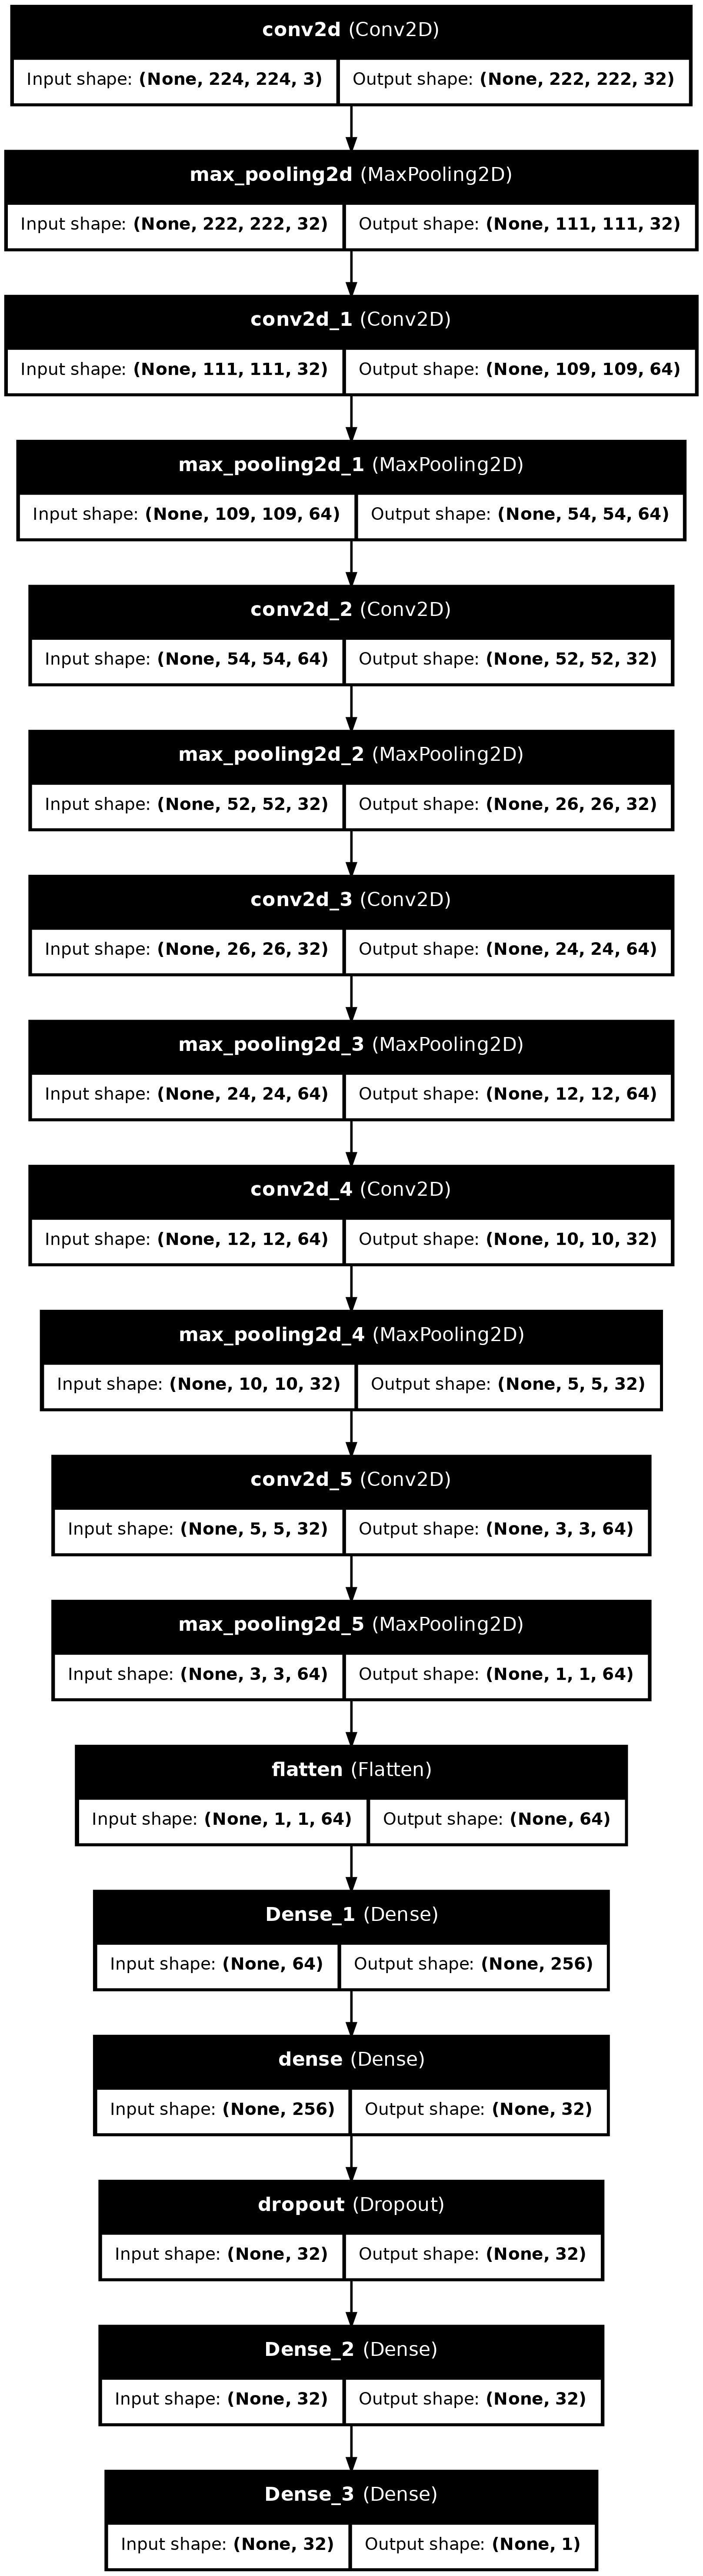

In [29]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Partie 6:

 - Entraînement du modèle


### Compiler votre modèle

In [30]:
# Compiler le model
model.compile(optimizer=optimizer,
    loss=loss,
    metrics=metrics)

#### Early stopping

In [31]:
early_stopping_cb = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = callbacks.ModelCheckpoint("model.h5", save_best_only=True)

### Entraînement du modèle

In [32]:
# Fit the model 
history = model.fit(x=x_train, y=y_train, 
                              epochs=epochs, 
                              validation_data=(x_val, y_val),
                              callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.4994 - loss: 0.6903

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.5026 - loss: 0.6900 - val_accuracy: 0.4924 - val_loss: 0.6946
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.5686 - loss: 0.6730

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.5683 - loss: 0.6732 - val_accuracy: 0.4924 - val_loss: 0.6871
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.5661 - loss: 0.6737

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.5656 - loss: 0.6735 - val_accuracy: 0.4924 - val_loss: 0.6866
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.5309 - loss: 0.6732 - val_accuracy: 0.4924 - val_loss: 0.6923
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5529 - loss: 0.6664

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.5556 - loss: 0.6655 - val_accuracy: 0.4924 - val_loss: 0.6694
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.5673 - loss: 0.6563

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - accuracy: 0.5693 - loss: 0.6556 - val_accuracy: 0.7803 - val_loss: 0.6230
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7342 - loss: 0.6202

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.7323 - loss: 0.6194 - val_accuracy: 0.6212 - val_loss: 0.6211
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.6288 - loss: 0.6278

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.6311 - loss: 0.6263 - val_accuracy: 0.6970 - val_loss: 0.5888
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - accuracy: 0.6592 - loss: 0.6126 - val_accuracy: 0.6136 - val_loss: 0.6119
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.6425 - loss: 0.6168 - val_accuracy: 0.5152 - val_loss: 0.7119


### Fonction coût pour l'ensemble d'entraînement et de validation

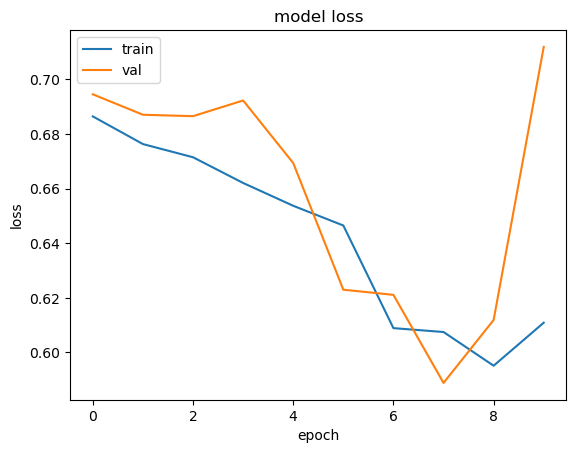

In [33]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Comparaison entre l'exactitude de l'ensemble d'entraînement et l'ensemble de validation

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
0.5151515007019043


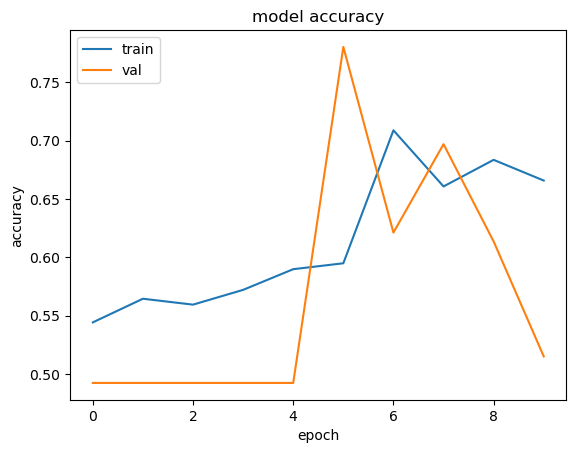

In [34]:

print(history.history.keys())
print(history.history['val_accuracy'][-1])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Partie 7:

 - Tester et valider le modèle

### Évaluation du model sur les jeux de données de l'ensenble de test

In [35]:
# Assuming you have a trained model
loss, accuracy = model.evaluate(x=x_val, y=y_val)
print(f"Val Loss: {loss}")
print(f"Val Accuracy: {accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7128 - loss: 0.5837
Val Loss: 0.5888498425483704
Val Accuracy: 0.6969696879386902



## Partie 8:

   - Inférence



In [36]:
model = load_model('model.h5')

In [37]:
proportion = ...

In [38]:
datasets_ = CustomDataset(proportion=proportion, root = root, train=False, size=(224,224),shuffle=True, normalize=True)

In [39]:
images_ , target_ = datasets_.dataloader()

In [40]:
labelstate = ['benign', 'malignant']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


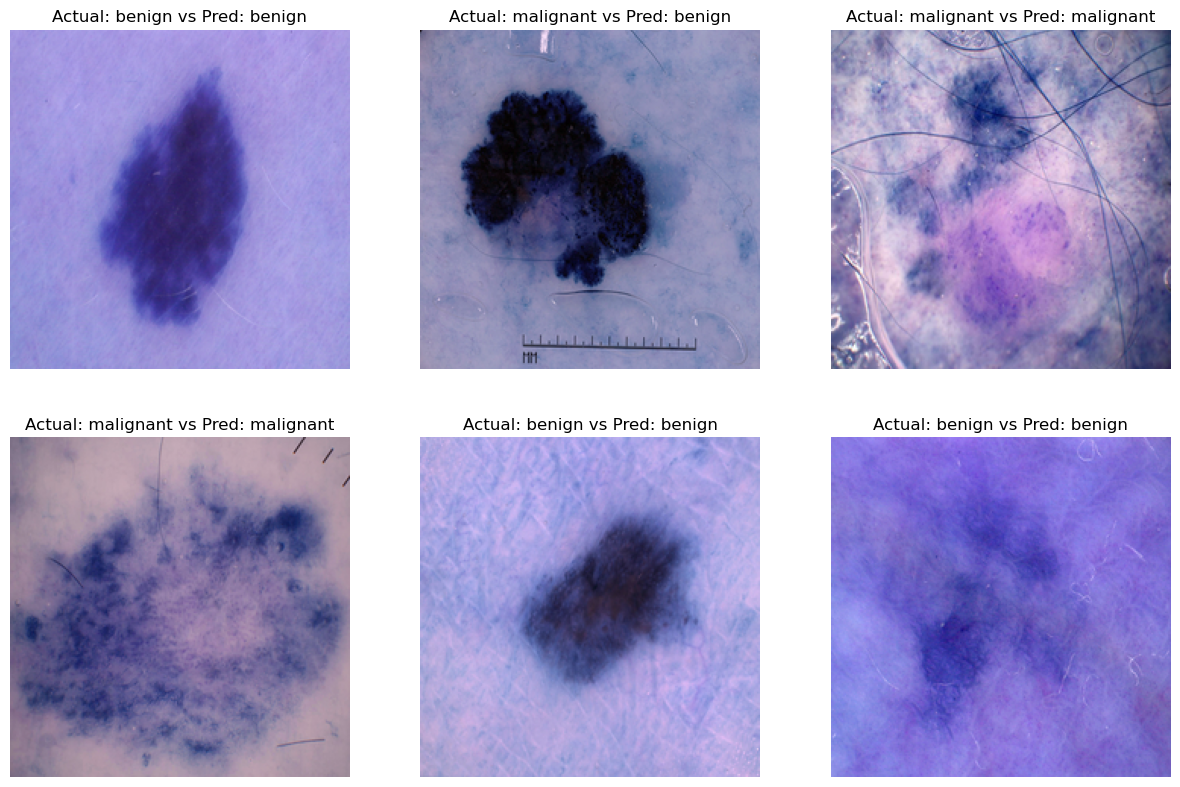

In [41]:
plt.figure(figsize=(15, 15))

i = 0

for  image, label in zip(images_[:9],target_[:9]):
    ax = plt.subplot(3, 3, i + 1)
    
    img = cv2.resize(image,(224,224))
    img = np.reshape(image,[1,224,224,3])

    pred = 0 if model.predict(img) <0.5 else 1
   
    plt.imshow(np.array(image*255).astype("uint8"))
    plt.title("Actual: "+label+" vs "+"Pred: "+labelstate[pred])
    plt.axis("off")
    i+=1

## Partie 9

 - Modèle pré-entraîné

#### Charger les poids pré-entraînés sur ImageNet

In [42]:
optimizer = 'adam'
loss = 'binary_crossentropy'
metrics=["accuracy"]

In [43]:
base_model = applications.Xception(
    weights="imagenet",  # Charger les poids pré-entraînés sur ImageNet.
    input_shape=(224, 224, 3),
    include_top=False, # Exclure la dernière couche de classification de ImageNet.
) 

#### Sommaire du modèle pré-entraîné

In [44]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

#### Bloquer les poids du modèle de base (ne pas les modifier)

In [45]:
for layer in base_model.layers:
    layer.trainable = False

#### Créer au-dessus du modèle pré-entraîné un nouveau modèle

In [46]:
inputs = Input(shape=(224, 224, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)

# Regularize with dropout
x = Dropout(0.3)(x)

outputs = Dense(1)(x)
model = Model(inputs, outputs)


In [47]:
model.summary(show_trainable=True)

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 7, 7, 2048)    │ 20,861,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 1)             │      2,049 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [48]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [49]:
early_stopping_cb = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = callbacks.ModelCheckpoint("modelft.h5", save_best_only=True)

#### Charger Données non normalisées

In [ ]:
datasets = CustomDataset(proportion=proportion, root = root, train=True, size=(224,224),shuffle=True, normalize=False)
images , target = datasets.dataloader()
target = [0 if item=='benign' else 1 for item in target]
X_Train = np.array(images)
Y_Train = np.array(target)

# À l'aide de sklearn, écrivez une fonction pour diviser les données en ensemble d'apprentissage et de validation
x_train, x_val, y_train, y_val = train_test_split(X_Train, Y_Train, test_size=0.25, shuffle=True, random_state=42)

In [50]:
 
history = model.fit(x=x_train, y=y_train, 
                              epochs=epochs, 
                              validation_data=(x_val, y_val),
                              callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.5740 - loss: 0.6831

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 918ms/step - accuracy: 0.5720 - loss: 0.6837 - val_accuracy: 0.4924 - val_loss: 0.6907
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.5782 - loss: 0.6892

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 895ms/step - accuracy: 0.5774 - loss: 0.6895 - val_accuracy: 0.4848 - val_loss: 0.6898
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 918ms/step - accuracy: 0.5423 - loss: 0.6957 - val_accuracy: 0.4924 - val_loss: 0.6939
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 935ms/step - accuracy: 0.5423 - loss: 0.6984 - val_accuracy: 0.4924 - val_loss: 0.6923
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 955ms/step - accuracy: 0.5350 - loss: 0.6886 - val_accuracy: 0.4924 - val_loss: 0.6941
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.5427 - loss: 0.6855

13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 984ms/step - accuracy: 0.5441 - loss: 0.6847 - val_accuracy: 0.4848 - val_loss: 0.6854
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 959ms/step - accuracy: 0.5979 - loss: 0.6864 - val_accuracy: 0.4848 - val_loss: 0.6895
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 954ms/step - accuracy: 0.5964 - loss: 0.6718 - val_accuracy: 0.4848 - val_loss: 0.6903
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.6148 - loss: 0.6643

13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 970ms/step - accuracy: 0.6134 - loss: 0.6652 - val_accuracy: 0.4924 - val_loss: 0.6835
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 953ms/step - accuracy: 0.5968 - loss: 0.6659 - val_accuracy: 0.4848 - val_loss: 0.6874


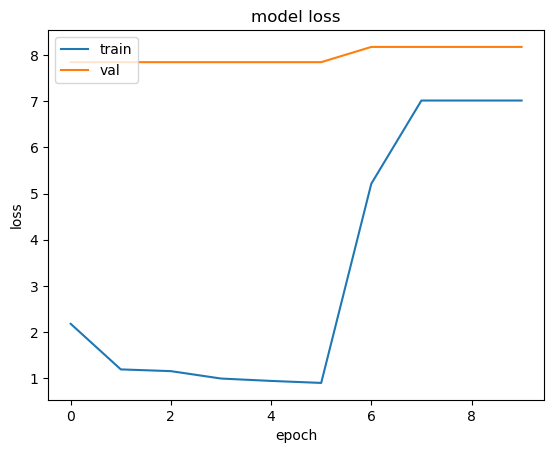

In [ ]:
# résumer l'historique des pertes
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
0.49242424964904785


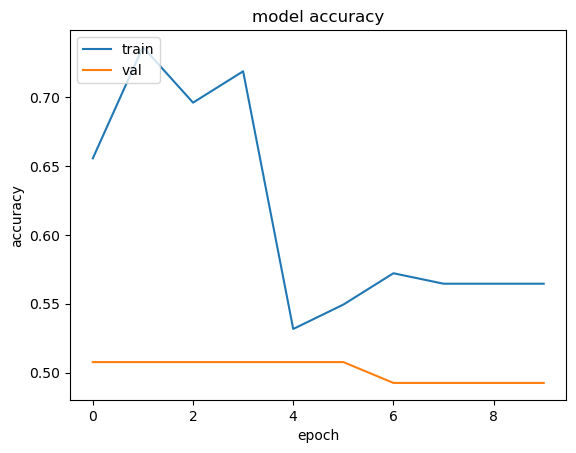

In [57]:

print(history.history.keys())
print(history.history['val_accuracy'][-1])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [345]:
# Assuming you have a trained model
loss, accuracy = model.evaluate(x=x_val, y=y_val)
print(f"Val Loss: {loss}")
print(f"Val Accuracy: {accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 571ms/step - accuracy: 0.6519 - loss: 0.6765
Val Loss: 0.6799370646476746
Val Accuracy: 0.6111111044883728


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


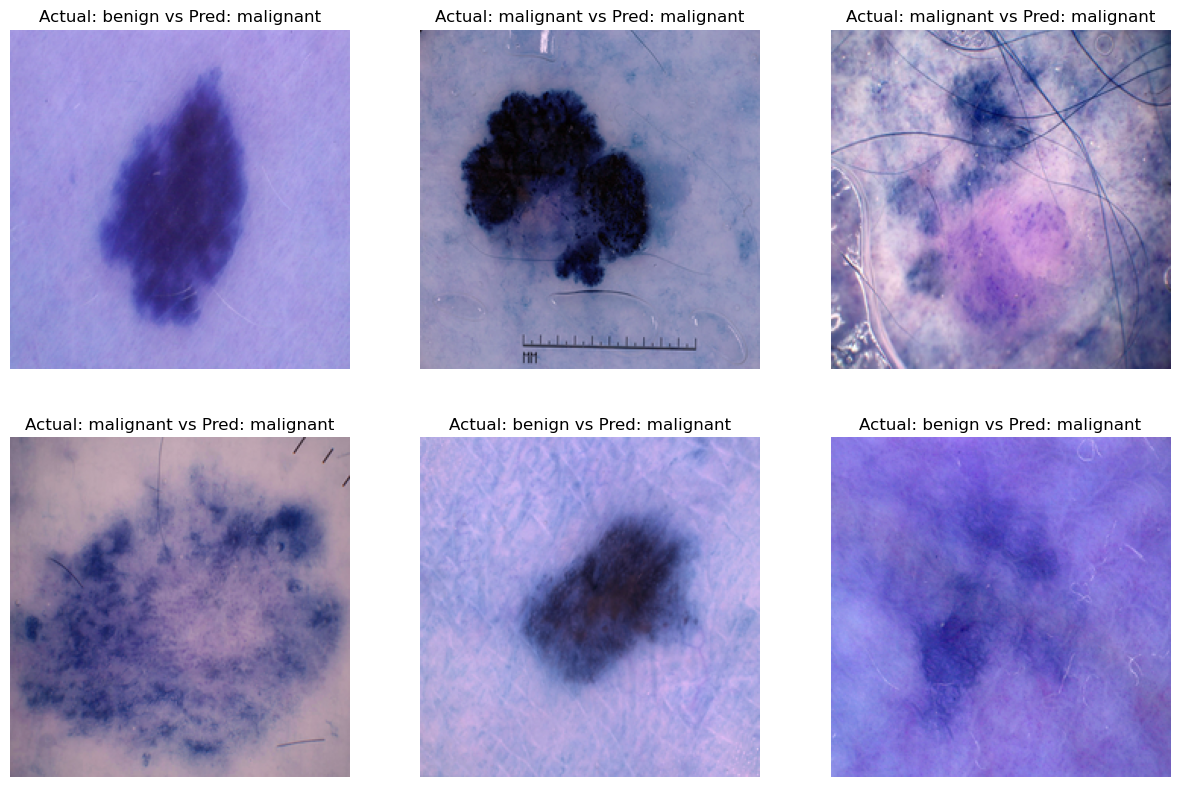

In [58]:
plt.figure(figsize=(15, 15))

i = 0

for  image, label in zip(images_[:9],target_[:9]):
    ax = plt.subplot(3, 3, i + 1)
    
    img = cv2.resize(image,(224,224))
    img = np.reshape(image,[1,224,224,3])

    pred = 0 if model.predict(img) <0.5 else 1
   
    plt.imshow(np.array(image*255).astype("uint8"))
    plt.title("Actual: "+label+" vs "+"Pred: "+labelstate[pred])
    plt.axis("off")
    i+=1

#### Définir les fonctions pour faire soi-même l'augmentation des données


 - Augmenter la liste (images) avec de nouvelles images 

 - Augmenter aussi les valeurs cibles (target)

In [ ]:
...

In [ ]:
...

In [ ]:
...

#### Utiliser ces données pour l'entraînement et l'inférence

In [ ]:
...

In [ ]:
...

In [ ]:
...

## Partie 10
 - Augmentation des données avec ImageDataGenerator

In [71]:
import os

def afficher_structure(repertoire, niveau=0, max_fichiers=2):
    """Affiche récursivement la structure du répertoire avec indentation en limitant à max_fichiers"""
    try:
        # Liste tous les fichiers et dossiers dans le répertoire
        contenu = os.listdir(repertoire)

        # Séparer les fichiers des dossiers
        fichiers = [item for item in contenu if os.path.isfile(os.path.join(repertoire, item))]
        dossiers = [item for item in contenu if os.path.isdir(os.path.join(repertoire, item))]

        # Trier les fichiers par date de modification (le plus récent en premier)
        fichiers.sort(key=lambda x: os.path.getmtime(os.path.join(repertoire, x)), reverse=True)

        # Limiter aux max_fichiers plus récents
        fichiers = fichiers[:max_fichiers]

        # Afficher les dossiers
        for dossier in dossiers:
            print(" " * niveau * 2 + f"📂 {dossier}")
            afficher_structure(os.path.join(repertoire, dossier), niveau + 1, max_fichiers)

        # Afficher les fichiers (seulement les deux plus récents)
        for fichier in fichiers:
            print(" " * niveau * 2 + f"📄 {fichier}")
    
    except PermissionError:
        print("Permission refusée pour", repertoire)


In [ ]:
# Spécifier le répertoire contenant l'ensemble d'entraînement et de test
repertoire = ".../cours/CV50/inputs/raw/"
afficher_structure(repertoire)


📂 data
  📂 train
    📂 malignant
      📄 785.jpg
      📄 877.jpg
    📂 benign
      📄 622.jpg
      📄 785.jpg
  📂 test
    📂 malignant
      📄 874.jpg
      📄 826.jpg
    📂 benign
      📄 874.jpg
      📄 826.jpg


In [73]:
# Définir les chemins vers les données d'entraînement et de test
training_dir=".../cours/CV50/inputs/raw/data/train"
test_dir=".../cours/CV50/inputs/raw/data/test"

In [74]:

def Augm_data(augmented : bool = True,batch_size : int =16):      
    if augmented:          
                          
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)
        
        validation_datagen = ImageDataGenerator(rescale=1./255)    

    else:
        
        train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
        validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
             
    return train_datagen , validation_datagen

In [76]:
train_datagen , validation_datagen = Augm_data(augmented  = True,batch_size  =16)

In [77]:
# Ensemble d'entraînement
train_set = train_datagen.flow_from_directory(
    training_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="sparse")

# Ensemble de test
validation_set = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size, 
    class_mode="sparse")

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [78]:
import os
import matplotlib.pyplot as plt


# Calculer la distribution de l'ensemble d'entraînement
train_class_counts = {}
for class_folder in os.listdir(training_dir):
    class_path = os.path.join(training_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        train_class_counts[class_folder] = num_images

# Calculer la distribution de l'ensemble de test
validation_class_counts = {}
for class_folder in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        validation_class_counts[class_folder] = num_images

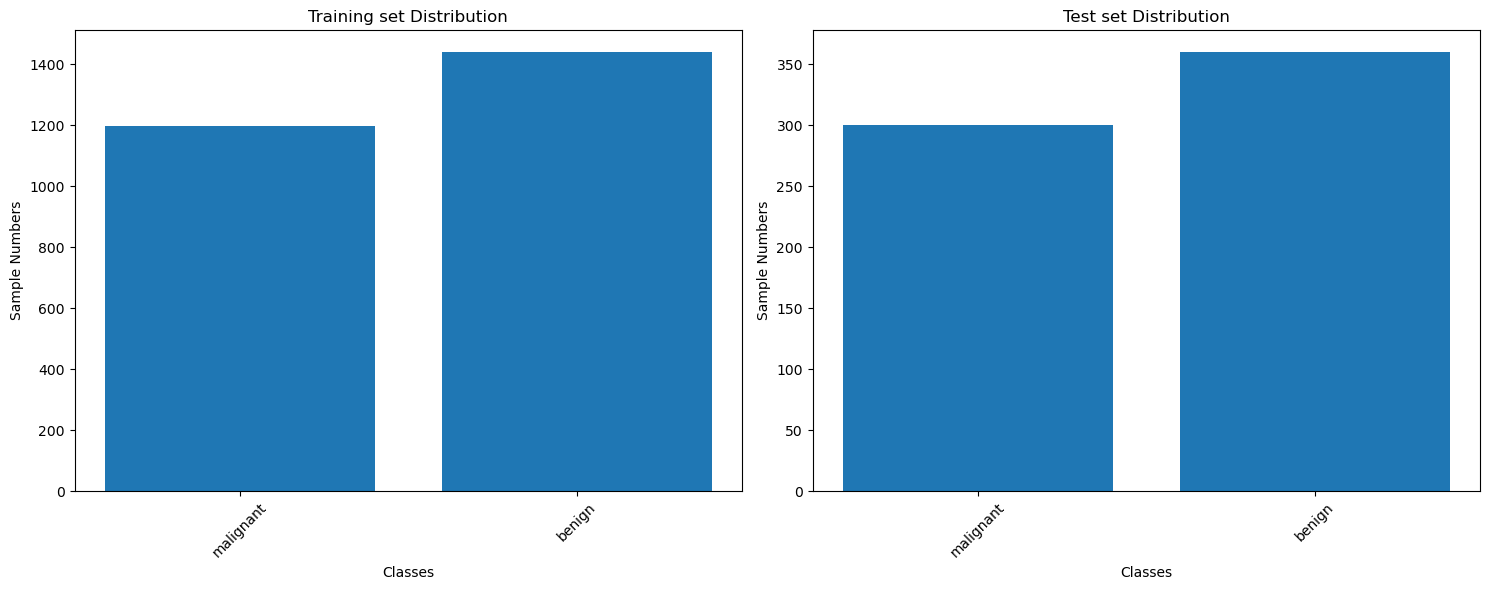

In [85]:
plt.figure(figsize=(15, 6))

# Distribution de l'ensemble d'entraînement
plt.subplot(1, 2, 1)
plt.bar(train_class_counts.keys(), train_class_counts.values())
plt.title('Training set Distribution')
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(rotation=45)

# Distribution de l'ensemble de test
plt.subplot(1, 2, 2)
plt.bar(validation_class_counts.keys(), validation_class_counts.values())
plt.title('Test set Distribution')
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [80]:
history = model.fit(
    train_set,  
    epochs=3,
    validation_data=validation_set)


Epoch 1/3


/home/laris/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


330/330 ━━━━━━━━━━━━━━━━━━━━ 289s 866ms/step - accuracy: 0.4636 - loss: 8.4999 - val_accuracy: 0.4545 - val_loss: 8.6958
Epoch 2/3
330/330 ━━━━━━━━━━━━━━━━━━━━ 291s 881ms/step - accuracy: 0.4584 - loss: 8.6340 - val_accuracy: 0.4545 - val_loss: 8.6958
Epoch 3/3
330/330 ━━━━━━━━━━━━━━━━━━━━ 286s 868ms/step - accuracy: 0.4533 - loss: 8.7159 - val_accuracy: 0.4545 - val_loss: 8.6958


In [83]:
import matplotlib.pyplot as plt

## fonction de visulisation pour les modèles
def visualize(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].plot(epochs, acc, 'r', label='Training acc')
    axs[0].plot(epochs, val_acc, 'b', label='Test acc')
    axs[0].set_title('Training and Test accuracy')
    axs[0].grid(True)
    axs[0].legend()
    
    axs[1].plot(epochs, loss, 'r', label='Training loss')
    axs[1].plot(epochs, val_loss, 'b', label='Test loss')
    axs[1].set_title('Training and test loss')
    axs[1].grid(True)
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

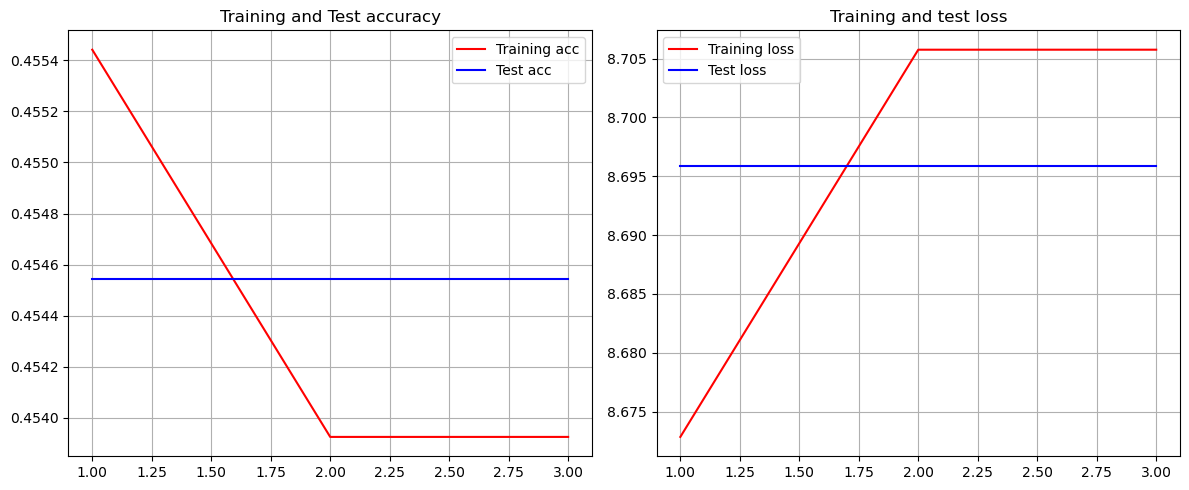

In [84]:
visualize(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


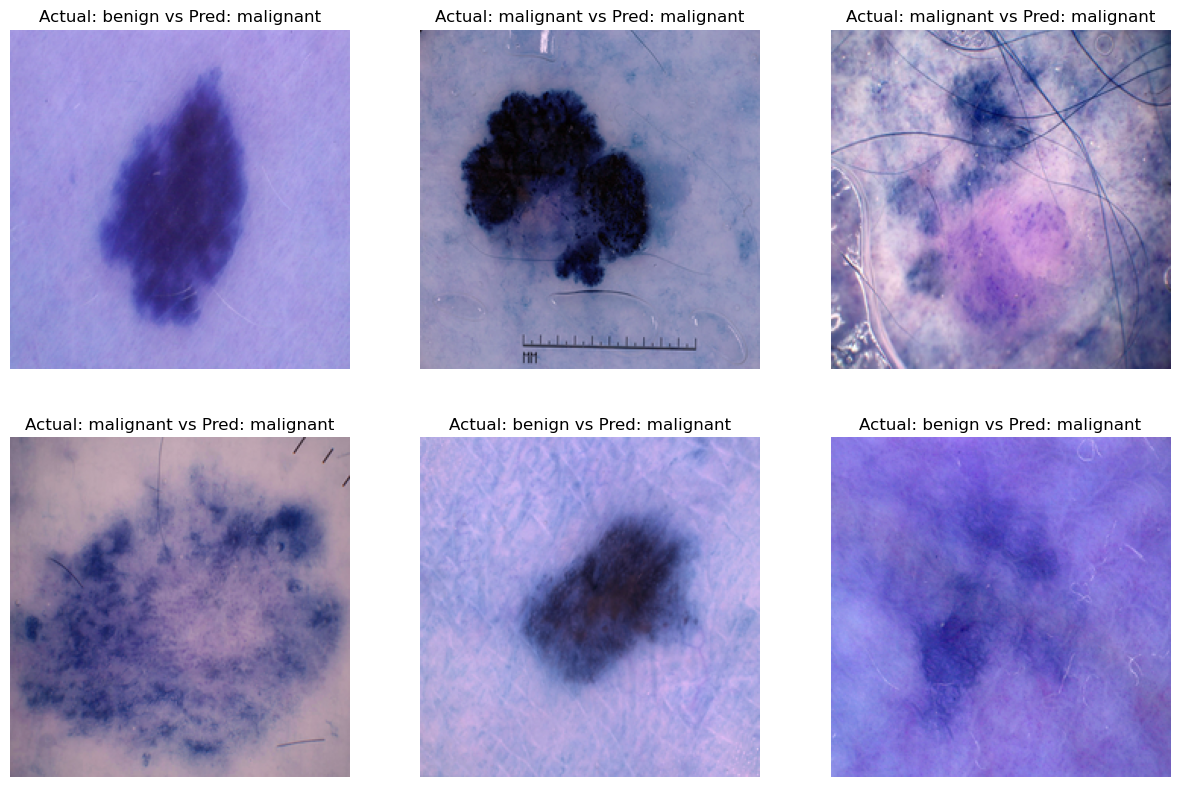

In [86]:
plt.figure(figsize=(15, 15))

i = 0

for  image, label in zip(images_[:9],target_[:9]):
    ax = plt.subplot(3, 3, i + 1)
    
    img = cv2.resize(image,(224,224))
    img = np.reshape(image,[1,224,224,3])

    pred = 0 if model.predict(img) <0.5 else 1
   
    plt.imshow(np.array(image*255).astype("uint8"))

    plt.title("Actual: "+label+" vs "+"Pred: "+labelstate[pred])
    
    plt.axis("off")
    i+=1